In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
vgg16 = models.vgg16(pretrained=True)

# Freeze the convolutional base to prevent updating weights during training
for param in vgg16.features.parameters():
    param.requires_grad = False

d:\Magister Program\Master Computer Science\Semester 2\Deep Learning\Session 2\Session 2\neural_network\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Magister Program\Master Computer Science\Semester 2\Deep Learning\Session 2\Session 2\neural_network\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
num_features = vgg16.classifier[6].in_features
num_classes = 3  
vgg16.classifier[6] = torch.nn.Linear(num_features, num_classes)
vgg16 = vgg16.to(device)

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))        
])

In [6]:
# Create an ImageFolder dataset
# Create ImageFolder datasets
train_dataset = ImageFolder(root='vegetable_images/train', transform=transform)
val_dataset = ImageFolder(root='vegetable_images/validation', transform=transform)
test_dataset = ImageFolder(root='vegetable_images/test', transform=transform)

# Create a data loader
batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.classifier.parameters(), lr=0.0001)

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(5):  # loop over the dataset multiple times
    vgg16.train()
    running_loss, running_acc = 0.0, 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += calculate_accuracy(outputs, labels)
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(running_acc / len(train_loader))

    vgg16.eval()
    val_loss, val_acc = 0.0, 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg16(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            val_acc += calculate_accuracy(outputs, labels)

            _, preds = torch.max(outputs, 1)  
            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_acc / len(val_loader))
    

    print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.2f}, Train Acc: {train_accs[-1]:.2f}, Val Loss: {val_losses[-1]:.2f}, Val Acc: {val_accs[-1]:.2f}')

Epoch 1, Train Loss: 0.03, Train Acc: 0.99, Val Loss: 0.00, Val Acc: 1.00
Epoch 2, Train Loss: 0.00, Train Acc: 1.00, Val Loss: 0.00, Val Acc: 1.00
Epoch 3, Train Loss: 0.00, Train Acc: 1.00, Val Loss: 0.00, Val Acc: 1.00
Epoch 4, Train Loss: 0.00, Train Acc: 1.00, Val Loss: 0.00, Val Acc: 1.00
Epoch 5, Train Loss: 0.00, Train Acc: 1.00, Val Loss: 0.00, Val Acc: 1.00


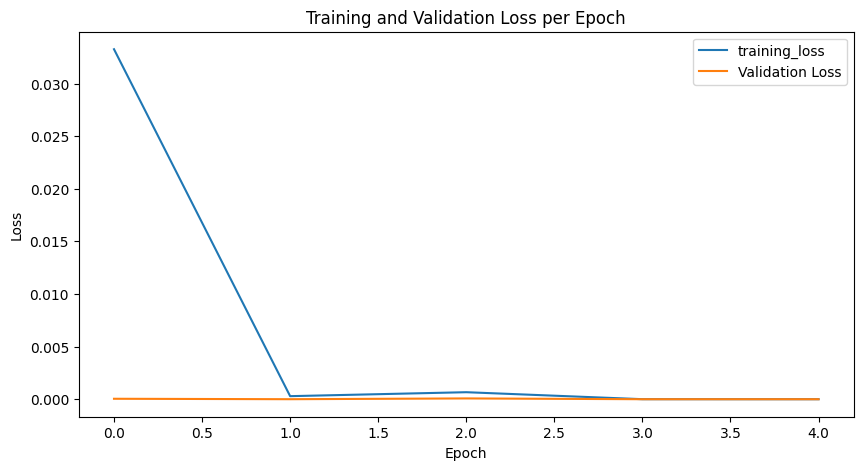

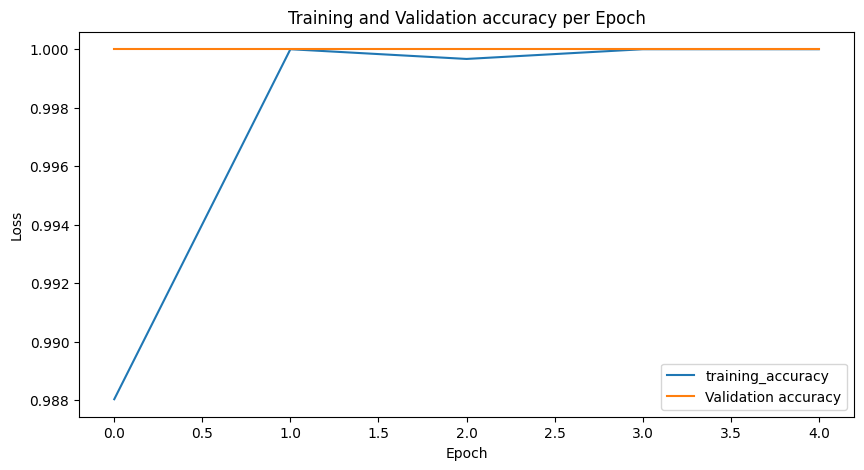

In [9]:
import matplotlib.pyplot as plt
# Plot training dan validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label = 'training_loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Plot training dan validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label = 'training_accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.title('Training and Validation accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
def calculate_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    return f1, cm

f1, cm = calculate_metrics(all_labels, all_preds)
print(f'Validation F1 Score: {f1:.2f}')

Validation F1 Score: 1.00


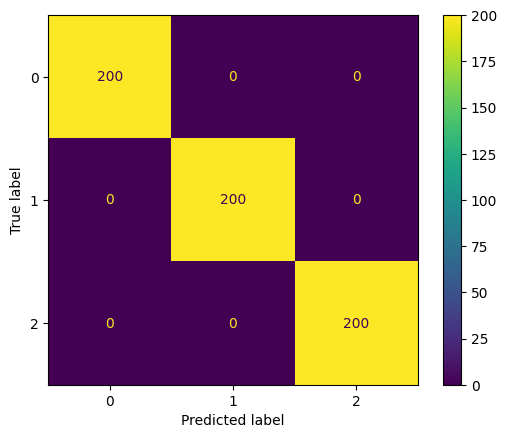

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               )
disp.plot()
plt.show()

In [12]:
from sklearn.metrics import classification_report
report = classification_report(all_labels, all_preds, target_names=["0", "1", "2"])
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       200
           2       1.00      1.00      1.00       200

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [13]:
torch.save(vgg16.state_dict(), 'vgg16_transfer_learning.pth')  #save the model has been trained

Predicted label: broccoli, confidence: 100.00%


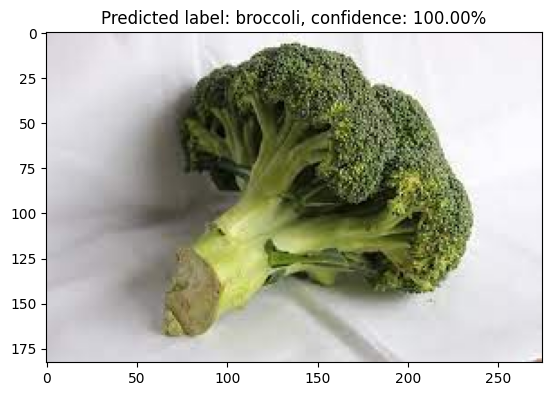

In [15]:
#Write your code for inference here
from PIL import Image

model = vgg16

# Load the weights
state_dict = torch.load('vgg16_transfer_learning.pth')
model.load_state_dict(state_dict)

# Switch to evaluation mode
model.eval()

# Now you can use model to perform inference
# Load and prepare the image
image_path = r'brokoli_3.jpeg'
input_image = Image.open(image_path)


# Define the same transforms that were used during the model training
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))        
])

# Apply the transforms to the image
input_tensor = transform(input_image)
input_batch = input_tensor.unsqueeze(0)  

# Move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

# Convert output logits to predicted class (index) and probabilities
probabilities = torch.nn.functional.softmax(output[0], dim=0)
max_value, predicted_class = torch.max(probabilities, 0)
classes = ('broccoli', 'cabbage', 'cauliflower')

# Print the result
class_name = classes[predicted_class.item()]
# print(f"Predicted label name: {class_name}")
print(f'Predicted label: {class_name}, confidence: {max_value.item() * 100:.2f}%')

# Show the input image
plt.imshow(input_image)
plt.title(f'Predicted label: {class_name}, confidence: {max_value.item() * 100:.2f}%')
plt.show()